In [41]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
class A2C_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 actor_network:torch.nn, 
                 critic_network:torch.nn,
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim,
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        self.device = device
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer              
        self.gamma = gamma
        
    def get_action(self, obs:np.ndarray) -> int:        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.actor_network(obs)
        dist = F.softmax(dist, dim = 0) # softmax here to avoid the gradient explosion in NN
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
               
        return picked_action.item()
    
    def calculate_log_prob(self, obs:torch.Tensor, action:torch.Tensor) -> torch.Tensor:
        dist = self.actor_network(obs)
        dist = F.softmax(dist, dim=0)
        log_prob = torch.log(dist.gather(0, action))
        
        return log_prob
    
    def train_policy(self,
                     obs:np.ndarray,
                     action:int,
                     reward:float,
                     next_obs:np.ndarray,
                     done:bool
                     ) -> None:
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        next_obs = torch.tensor(next_obs, dtype = torch.float32).to(self.device)
        current_V = self.critic_network(obs)
        next_V = self.critic_network(next_obs)
        TD_target = reward + self.gamma * next_V * (1 - float(done))
        TD_error = TD_target - current_V
        
        action = torch.tensor(action, dtype = torch.int64).to(self.device)
        log_prob = self.calculate_log_prob(obs, action)

        critic_loss =  F.mse_loss(current_V, TD_target.detach())
        actor_loss = -log_prob * TD_error.detach() # Detach means to fix the TD_error, so that the actor network will not be updated by the critic loss.
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

In [43]:
class Actor_Network(torch.nn.Module):

    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Actor_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x
    
class Critic_Network(torch.nn.Module):

    def __init__(self,obs_dim:int) -> None:
        super(Critic_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,1)
                    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x

In [44]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 actor_lr:float = 1e-3,
                 critic_lr:float = 1e-3,
                 gamma:float = 0.9,
                 seed = 0,
                 my_device = "cpu"
                 ) -> None:
        
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
    
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        actor_network = Actor_Network(obs_dim,action_dim).to(self.device)
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=actor_lr)
        critic_network = Critic_Network(obs_dim).to(self.device)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=critic_lr)
        self.agent = A2C_Agent(actor_network = actor_network,
                               critic_network = critic_network,
                               actor_optimizer = actor_optimizer,
                               critic_optimizer = critic_optimizer,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.index_episode = 0    
        
    def train_episode(self) -> float:
        total_reward = 0
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.agent.train_policy(obs, action, reward, next_obs, done)
            total_reward += reward 
            obs = next_obs                     
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        return total_reward
    
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
                
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

Episode 0: Total Reward = 19.00
Episode 100: Total Reward = 192.00
Episode 200: Total Reward = 174.00
Episode 300: Total Reward = 200.00
Episode 400: Total Reward = 200.00
Episode 500: Total Reward = 134.00
Episode 600: Total Reward = 140.00
Episode 700: Total Reward = 127.00
Episode 800: Total Reward = 69.00
Episode 900: Total Reward = 82.00


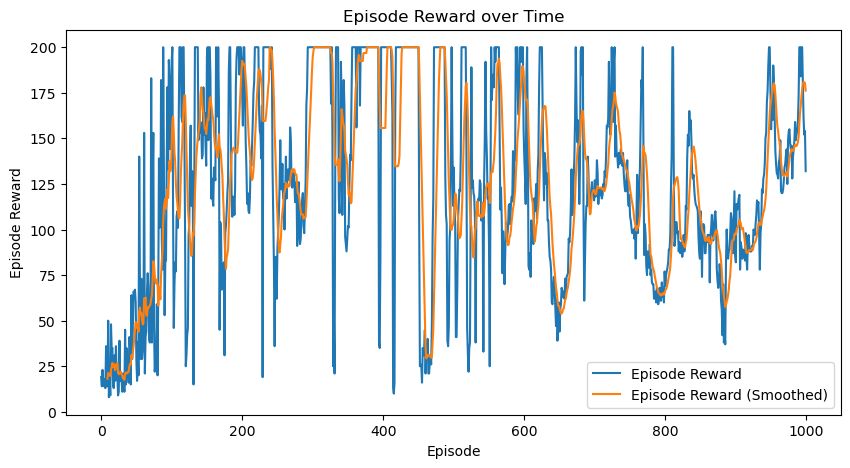

In [45]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        actor_lr = 1e-3,
                        critic_lr = 1e-2,
                        gamma = 0.98,
                        seed = 0,
                        my_device = "cpu" 
                        )
    Manger.train()
    Manger.plotting(smoothing_window = 10)